## Assignment for Module 3

Kai Zheng

April 22, 2022

### 1 Introduction

Use the expected value of the discounted payoff under the risk-neutral density $\mathbb{Q}$

$$
V(S, t) = e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}[\textbf{Payoff}(S_T)]
$$

for the appropriate form of payoff, to consider **Asian** and **Lookback** options.

Use the **Euler-Maruyama** (only) scheme for initially simulating the underlying stock price. As an initial example you may use the following set of sample data

\begin{aligned}
    Today's \ stock \ price \ S_0 &= 100 \\
    Strike \ E &= 100 \\
    Time \ to \ expiry \ (T - t) &= 1 \ year \\
    Volatility \ \sigma &= 20\% \\
    Constant \ risk\text{--}free \ interest \ rate \ r &= 5\%
\end{aligned}

Then vary the data to see the affect on the option price.

### 2 Methodology

#### 2.1 Asset Pricing

Following Black-Scholes-Merton where the underlying follows under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE) is given to simulate the asset price at maturity $S_T$ as
$$
    dS_t = \mu S_t dt + \sigma S_t dW_t
$$
where $S_t$ is the price of the underlying at time $t$, $\sigma$ is constant volatility, $r$ is the constant risk-free interest rate and $W$ is the brownian motion.

Applying **Euler-Maruyama** discretization of SDE, we get
$$
    S_{t+\delta t} = S_t * (1 + r\delta t + \sigma \sqrt{\delta t w_t})
$$
It is often more convenient to express in time stepping form
$$
    S_{t+\delta t} = S_t * e^{((r-\frac{1}{2} \sigma^2)\delta t + \sigma \sqrt{\delta t w_t})}
$$
The variable $w$ is a standard normally distributed random variable, $0 < \delta t < T$, time interval. It also holds $0 < t ≤ T$ with $T$, the final time horizon.

#### 2.2 Variance Reduction

Monte Carlo methods are simulation algorithms to estimate a numerical quantity in a statistical model. There are few methods that provide for high accurary. Variance reduction techniques such as a) antithetic variates, b) control variates and c) moment matching are widely adopted.

In antithetic variates, we try to reduce the variance by introducing negative dependence between pairs of random draws while in moment matching, we correct the set of standard normal pseudo-random numbers generated by Python to match the first two moments correctly. In control variates method, we exploit information about the errors in estimates of known quantities to reduce the error of an estimate of an unknown quantity. 

Python functions generate pseudorandom numbers that might exhibit the expected statistical behaviour. We try to achieve the desired property by employing variance reduction techniques. 

#### 2.3 Option Price

To price an option using a Monte Carlo simulation we use a risk-neutral valuation, where the fair value for a derivative is the expected value of its future payoff. So at any date before maturity, denoted by $t$, the option's value is the present value of the expectation of its payoff at maturity, $T$.

$$
    C = PV(E[payoff])
$$

Under the risk-neutral framework, we assume the asset is going to earn, on average, the risk-free interest rate. Hence, the option value at time  t  would simply be the discounted value of the expected payoff.

$$
    C = e^{-r(T-t)}(E[payoff])
$$

#### 2.4 Asian Option

An Asian option is an option where the payoff depends on the average price of the underlying asset over a certain period of time. 

##### 2.4.1 Types of Average

- Continuous arithmetic average

$$
    A = \frac{1}{T} \int_0^T S(\tau)d\tau
$$

- Continuous geometric average

$$
    A = e^{\frac{1}{t} \int_0^t lnS(\tau)d\tau}
$$

- Discrete arithmetic averages

$$
    A = \frac{1}{T} \sum \limits_{i = 0}^T S(t_i)
$$

- Discrete geometric average

$$
    A = e^{\frac{1}{T} \sum \limits_{i = 0}^T lnS(t_i)}
$$

##### 2.4.2  Types of Payoff

The payoff types can be classified into **strike** and **rate**. These classifications work as follows.

| Classification      | Payoff Formula  |
|---------------------|-----------------|
| average strike call | $$max(S-A, 0)$$ |
| average strike put  | $$max(A-S, 0)$$ |
| average rate call   | $$max(A-E, 0)$$ |
| average rate put    | $$max(E-A, 0)$$ |

where $S$ is the stock price, $E$ is the strike price and $A$ is the average price of the underlying asset over the life of the option. 

#### 2.5 Lookback Option

The lookback option has a payoff that depends on the maximum or minimum of the realized asset price. Here we will talk about the 'Maximum' of the asset.

##### 2.5.1 Types of Maximum

- Continuous maximum

$$
    M = \mathop{max}\limits_{0 \le \tau \le t}(S(\tau))
$$

- Discrete maximum

$$
    M_i = max(S(t_i), M_{i-1})
$$

##### 2.5.2  Types of Payoff

The payoff types can be classified into **fixed strike** and **floating strike**. These classifications work as follows.


| Classification      | Payoff Formula  |
|---------------------|-----------------|
| fixed strike call   | $$max(S-M, 0)$$ |
| fixed strike put    | $$max(M-S, 0)$$ |
| floating strike call| $$max(M-E, 0)$$ |
| floating strike put | $$max(E-M, 0)$$ |

where $S$ is the stock price, and $E$ is the strike price.

### 3 Experiments

#### 3.1 Monte Carlo Simulation

In [88]:
import pandas as pd
import numpy as np

from tabulate import tabulate

import matplotlib.pyplot as plt
import cufflinks as cf
cf.set_config_file(offline=True)

pd.set_option('display.max_rows', 300)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%reload_ext autoreload
%autoreload 2 

In [89]:
s0 = 100
strike = 100
horizon = 1
sigma = 0.2
mu = r = 0.05
timesteps = 252
n_sims = 100

In [90]:
from options import Option

option = Option(s0, strike, mu, sigma, horizon, timesteps, n_sims)
# option.monte_carlo_simulate()

asset_price_path = pd.DataFrame(option.S)
asset_price_path.iloc[:,:100].iplot(title='Simulated Geometric Brownian Motion Paths', xTitle='Time Steps', yTitle='Index Levels')
asset_price_path.shape

(252, 100)

#### 3.2 Asian Option Pricing

##### 3.2.1 Average

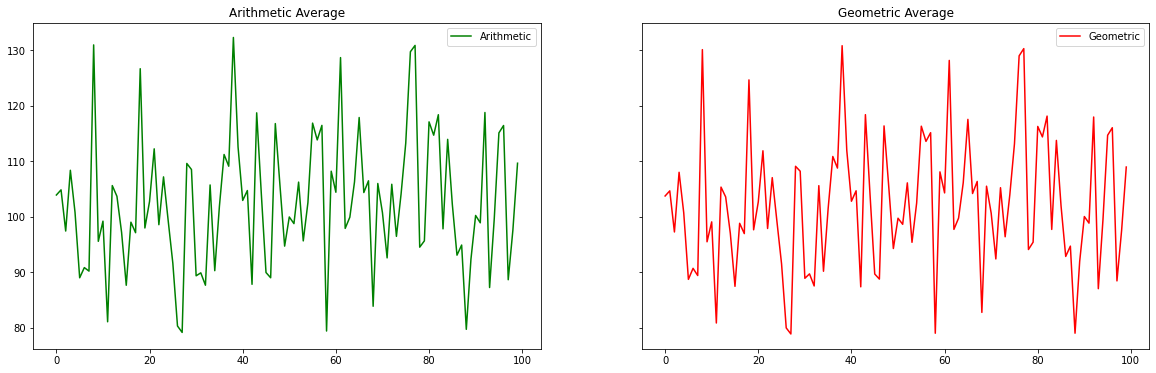

In [91]:
# arighmetic average and geometric average

from options import AsianOption

asian_option = AsianOption(s0, strike, mu, sigma, horizon, timesteps, n_sims)

arighmetic_avg = asian_option.arighmetic_average()
geometric_avg = asian_option.geometric_average()

figure, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)
title, data, color, label = ['Arithmetic Average', 'Geometric Average'], [arighmetic_avg, geometric_avg], ['green', 'red'], ['Arithmetic', 'Geometric']

for i in range(2):
    axes[i].plot(data[i], color=color[i], label=label[i])
    axes[i].set_title(title[i])
    axes[i].legend()

In [92]:
table = [
            ['arighmetic average', arighmetic_avg[0:5]],
            ['geometric average', geometric_avg[0:5]],
        ]

print(tabulate(table, tablefmt='grid'))

+--------------------+--------------------------------------------------------------------+
| arighmetic average | [103.89520988 104.82497314  97.40147502 108.35442779 100.78667457] |
+--------------------+--------------------------------------------------------------------+
| geometric average  | [103.71909054 104.64408219  97.2326006  107.99318288 100.67460939] |
+--------------------+--------------------------------------------------------------------+


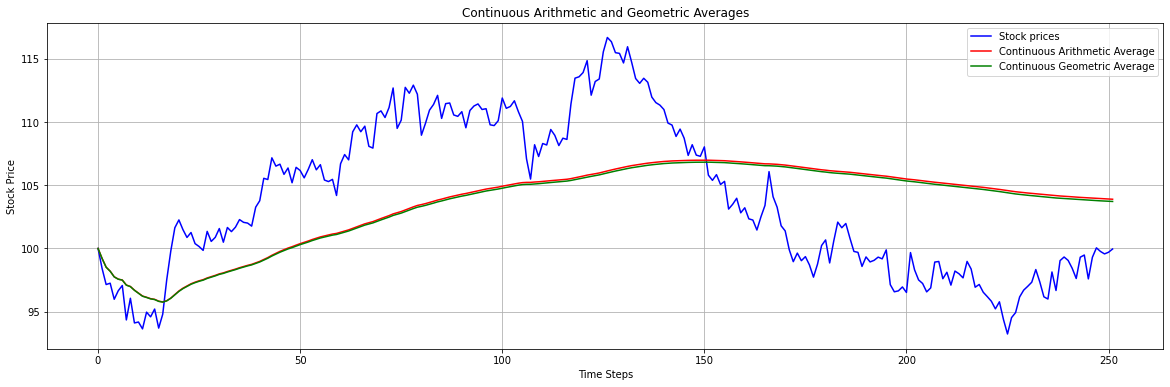

In [93]:
# continuous average

index = 0
array = asian_option.S[:, index]

continuous_arighmetic_average = asian_option.continuous_arighmetic_average(array)
continuous_geometric_average = asian_option.continuous_geometric_average(array)

plt.figure(figsize=(20, 6))
plt.plot(array, color = 'b', label = 'Stock prices')
plt.plot(continuous_arighmetic_average, color = 'r', label = 'Continuous Arithmetic Average')
plt.plot(continuous_geometric_average, color = 'g', label = 'Continuous Geometric Average')
plt.grid(True)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Continuous Arithmetic and Geometric Averages')
plt.legend()

In [94]:
table = [
            ['continuous arighmetic average', continuous_arighmetic_average[0:5]],
            ['continuous geometric average', continuous_geometric_average[0:5]],
        ]

print(tabulate(table, tablefmt='grid'))

+-------------------------------+--------------------------------------------------------------------+
| continuous arighmetic average | [100.          99.2092088   98.52181019  98.20417798  97.75946269] |
+-------------------------------+--------------------------------------------------------------------+
| continuous geometric average  | [100.          99.20605707  98.51490508  98.19746817  97.75003597] |
+-------------------------------+--------------------------------------------------------------------+


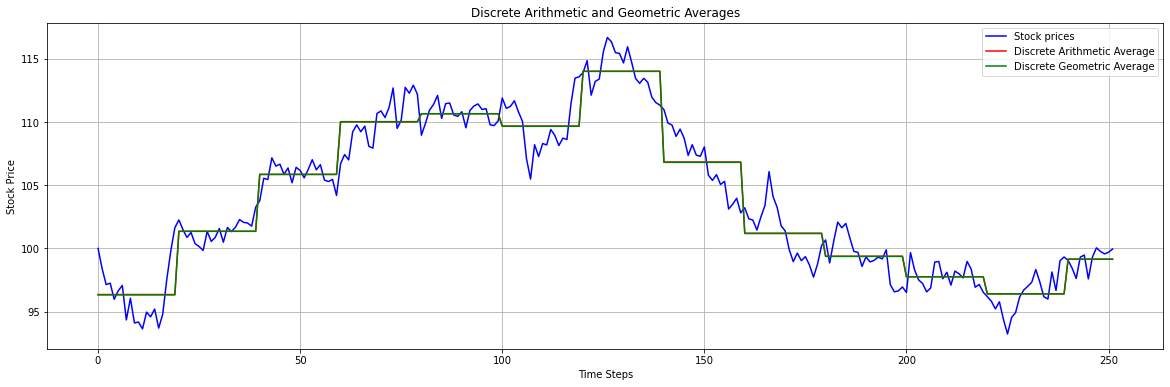

In [95]:
# discrete average

index = 0
window_size = 20
array = asian_option.S[:, index]

discrete_arighmetic_average = asian_option.discrete_arighmetic_average(array, window_size)
discrete_geometric_average = asian_option.discrete_geometric_average(array, window_size)

plt.figure(figsize=(20, 6))
plt.plot(array, color = 'b', label = 'Stock prices')
plt.plot(discrete_arighmetic_average, color = 'r', label = 'Discrete Arithmetic Average')
plt.plot(discrete_geometric_average, color = 'g', label = 'Discrete Geometric Average')
plt.grid(True)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Discrete Arithmetic and Geometric Averages')
plt.legend()


In [96]:
table = [
            ['discrete arighmetic average', discrete_arighmetic_average[0:5]],
            ['discrete geometric average', discrete_geometric_average[0:5]],
        ]

print(tabulate(table, tablefmt='grid'))

+-----------------------------+---------------------------------------------------------------+
| discrete arighmetic average | [96.35511096 96.35511096 96.35511096 96.35511096 96.35511096] |
+-----------------------------+---------------------------------------------------------------+
| discrete geometric average  | [96.32993432 96.32993432 96.32993432 96.32993432 96.32993432] |
+-----------------------------+---------------------------------------------------------------+


According the above result, there is no significant difference between the arithmetic average and the geometric average. So, we use the **Arithmetic Average** in the following experiment.

##### 3.2.2 Call and Put

Text(0.5, 1.0, 'Continuous Rate Put')

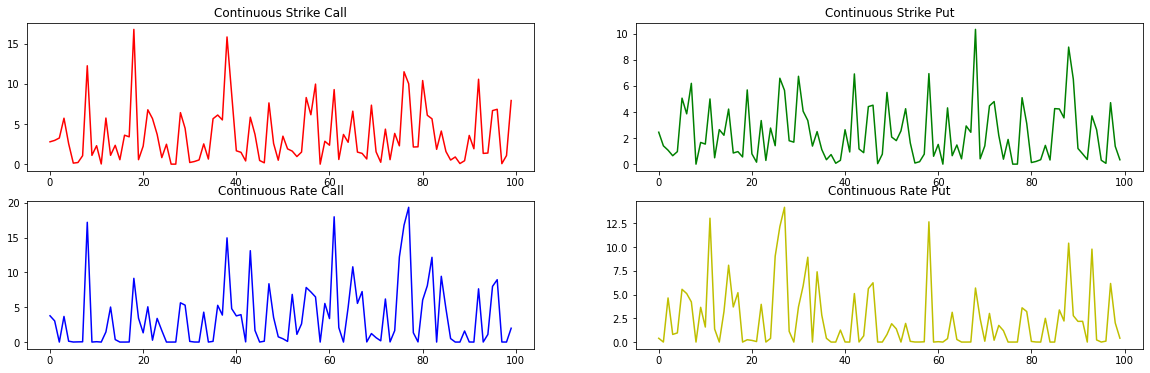

In [97]:
# Continuous Arithmetic Average Call, Put

c_strike_calls, c_strike_puts, c_rate_calls, c_rate_puts = asian_option.payoff_continuous_arighmetic_average()

figure, axes = plt.subplots(2, 2, figsize=(20,6))

axes[0, 0].plot(c_strike_calls, color='r')
axes[0, 0].set_title('Continuous Strike Call')

axes[0, 1].plot(c_strike_puts, color='g')
axes[0, 1].set_title('Continuous Strike Put')

axes[1, 0].plot(c_rate_calls, color='b')
axes[1, 0].set_title('Continuous Rate Call')

axes[1, 1].plot(c_rate_puts, color='y')
axes[1, 1].set_title('Continuous Rate Put')


In [98]:
table = [
            ['Continuous Strike', np.mean(c_strike_calls), np.mean(c_strike_puts)],
            ['Continuous Rate', np.mean(c_rate_calls), np.mean(c_rate_puts)],
        ]

header = ['Payoff', 'Call', 'Put']

print(tabulate(table, headers=header, tablefmt='grid'))

+-------------------+---------+---------+
| Payoff            |    Call |     Put |
+===================+=========+=========+
| Continuous Strike | 3.55382 | 2.34629 |
+-------------------+---------+---------+
| Continuous Rate   | 3.59115 | 2.39616 |
+-------------------+---------+---------+


Text(0.5, 1.0, 'Discrete Rate Put')

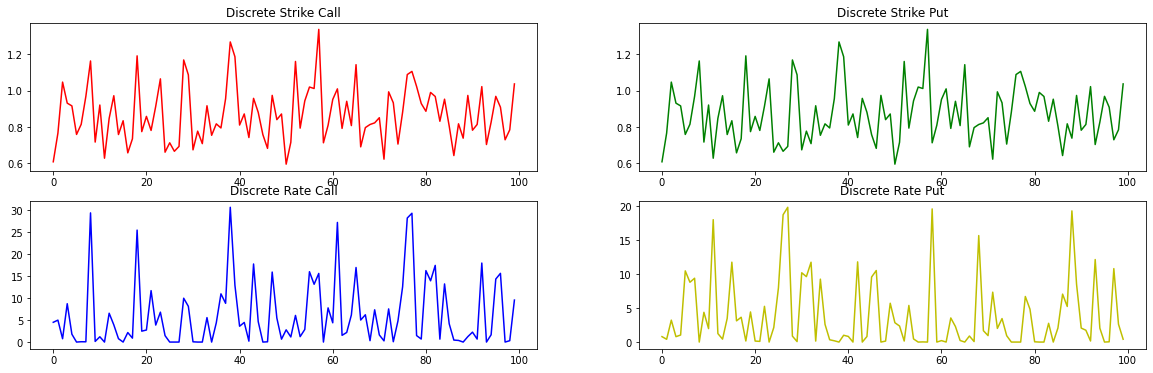

In [99]:
# Discrete Arithmetic Average Call, Put

d_strike_calls, d_strike_puts, d_rate_calls, d_rate_puts = asian_option.payoff_discrete_arighmetic_average(window_size)

figure, axes = plt.subplots(2, 2, figsize=(20,6))

axes[0, 0].plot(d_strike_calls, color='r')
axes[0, 0].set_title('Discrete Strike Call')

axes[0, 1].plot(d_strike_puts, color='g')
axes[0, 1].set_title('Discrete Strike Put')

axes[1, 0].plot(d_rate_calls, color='b')
axes[1, 0].set_title('Discrete Rate Call')

axes[1, 1].plot(d_rate_puts, color='y')
axes[1, 1].set_title('Discrete Rate Put')


In [100]:
table = [
            ['Discrete Strike', np.mean(d_strike_calls), np.mean(d_strike_puts)],
            ['Discrete Rate', np.mean(d_rate_calls), np.mean(d_rate_puts)],
        ]

header = ['Payoff', 'Call', 'Put']

print(tabulate(table, headers=header, tablefmt='grid'))

+-----------------+----------+----------+
| Payoff          |     Call |      Put |
+=================+==========+==========+
| Discrete Strike | 0.870411 | 0.870411 |
+-----------------+----------+----------+
| Discrete Rate   | 6.26637  | 3.86386  |
+-----------------+----------+----------+


#### 3.3 Lookback Option Pricing

##### 3.3.1 Maximum

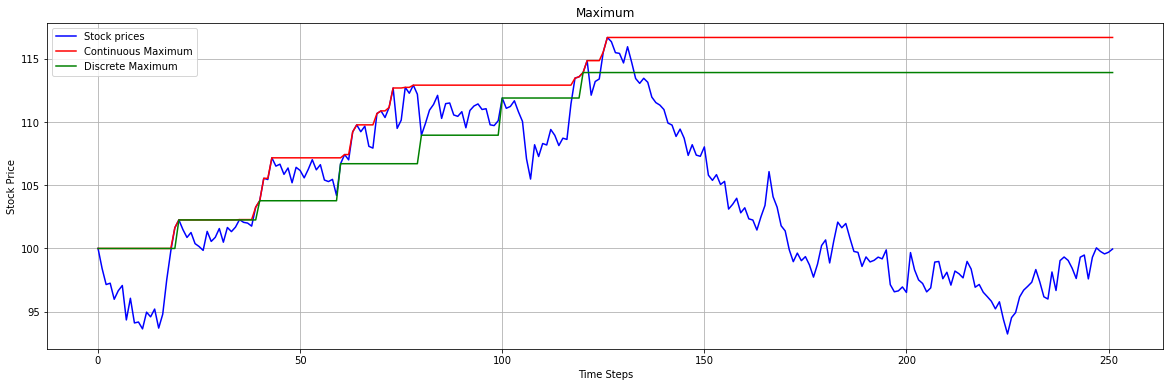

In [101]:
from options import LookbackOption

lookback_option = LookbackOption(s0, strike, mu, sigma, horizon, timesteps, n_sims)

index = 0
window_size = 20
array = lookback_option.S[:, index]

continuous_maximum = lookback_option.continuous_maximum(array)
discrete_maximum = lookback_option.discrete_maximum(array, window_size)

plt.figure(figsize=(20, 6))
plt.plot(array, color = 'b', label = 'Stock prices')
plt.plot(continuous_maximum, color = 'r', label = 'Continuous Maximum')
plt.plot(discrete_maximum, color = 'g', label = 'Discrete Maximum')
plt.grid(True)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Maximum')
plt.legend()

##### 3.3.2 Call and Put

Text(0.5, 1.0, 'Continuous Floating Strike Put')

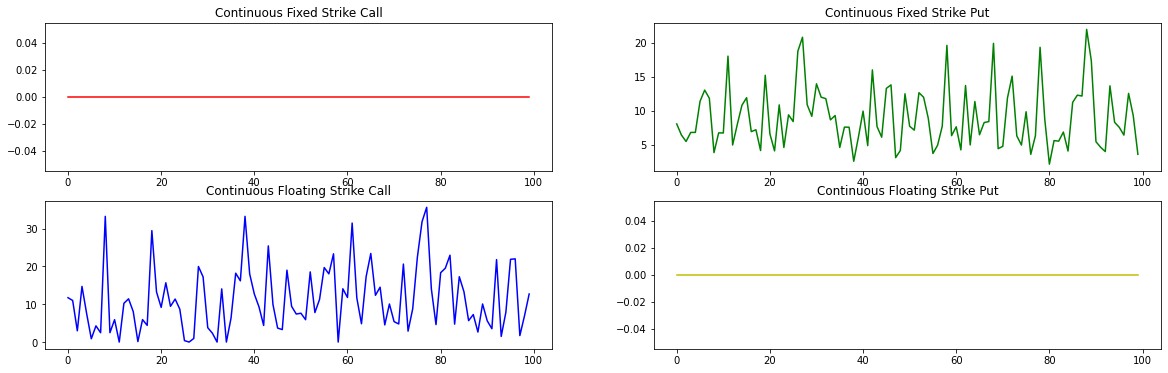

In [102]:
# Continuous Payoff

c_fixed_calls, c_fixed_puts, c_floating_calls, c_floating_puts = lookback_option.payoff_continuous()

figure, axes = plt.subplots(2, 2, figsize=(20,6))

axes[0, 0].plot(c_fixed_calls, color='r')
axes[0, 0].set_title('Continuous Fixed Strike Call')

axes[0, 1].plot(c_fixed_puts, color='g')
axes[0, 1].set_title('Continuous Fixed Strike Put')

axes[1, 0].plot(c_floating_calls, color='b')
axes[1, 0].set_title('Continuous Floating Strike Call')

axes[1, 1].plot(c_floating_puts, color='y')
axes[1, 1].set_title('Continuous Floating Strike Put')

In [103]:
table = [
            ['Continuous Fixed', np.mean(c_fixed_calls), np.mean(c_fixed_puts)],
            ['Continuous Floating', np.mean(c_floating_calls), np.mean(c_floating_puts)],
        ]

header = ['Strike Payoff', 'Call', 'Put']

print(tabulate(table, headers=header, tablefmt='grid'))

+---------------------+---------+---------+
| Strike Payoff       |    Call |     Put |
+=====================+=========+=========+
| Continuous Fixed    |  0      | 8.96754 |
+---------------------+---------+---------+
| Continuous Floating | 11.3701 | 0       |
+---------------------+---------+---------+


Text(0.5, 1.0, 'Discrete Floating Strike Put')

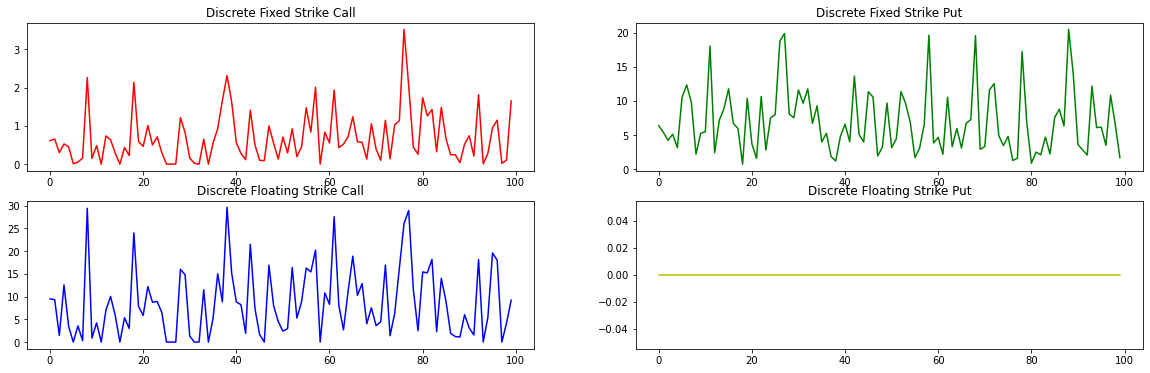

In [104]:
# Discrete Payoff

d_fixed_calls, d_fixed_puts, d_floating_calls, d_floating_puts = lookback_option.payoff_discrete(window_size)

figure, axes = plt.subplots(2, 2, figsize=(20,6))

axes[0, 0].plot(d_fixed_calls, color='r')
axes[0, 0].set_title('Discrete Fixed Strike Call')

axes[0, 1].plot(d_fixed_puts, color='g')
axes[0, 1].set_title('Discrete Fixed Strike Put')

axes[1, 0].plot(d_floating_calls, color='b')
axes[1, 0].set_title('Discrete Floating Strike Call')

axes[1, 1].plot(d_floating_puts, color='y')
axes[1, 1].set_title('Discrete Floating Strike Put')

In [105]:
table = [
            ['Discrete Fixed', np.mean(d_fixed_calls), np.mean(d_fixed_puts)],
            ['Discrete Floating', np.mean(d_floating_calls), np.mean(d_floating_puts)],
        ]

header = ['Strike Payoff', 'Call', 'Put']

print(tabulate(table, headers=header, tablefmt='grid'))

+-------------------+---------+---------+
| Strike Payoff     |    Call |     Put |
+===================+=========+=========+
| Discrete Fixed    | 0.6892  | 6.95981 |
+-------------------+---------+---------+
| Discrete Floating | 8.67312 | 0       |
+-------------------+---------+---------+


### 4 Discussion

#### 4.1 Design

Vary the variables to see the affect on the option price.

| Variables               | Range                 |
|-------------------------|-----------------------|
| Strike                  | range(100, 1000, 100) |
| Time to Expiry          | range(0.5, 10, 0.5)   |
| Volatility              | range(10, 1000, 20)    |
| Risk-Free Interest Rate | range(0, 20, 2)       |


#### 4.2 Strike

In [106]:
from options import AsianOption, LookbackOption

s0 = 100
strike = 100
horizon = 1
sigma = 0.2
mu = r = 0.05
timesteps = 252
n_sims = 100
window_size = 20

Text(0.5, 0.98, 'Asian options (Strike)')

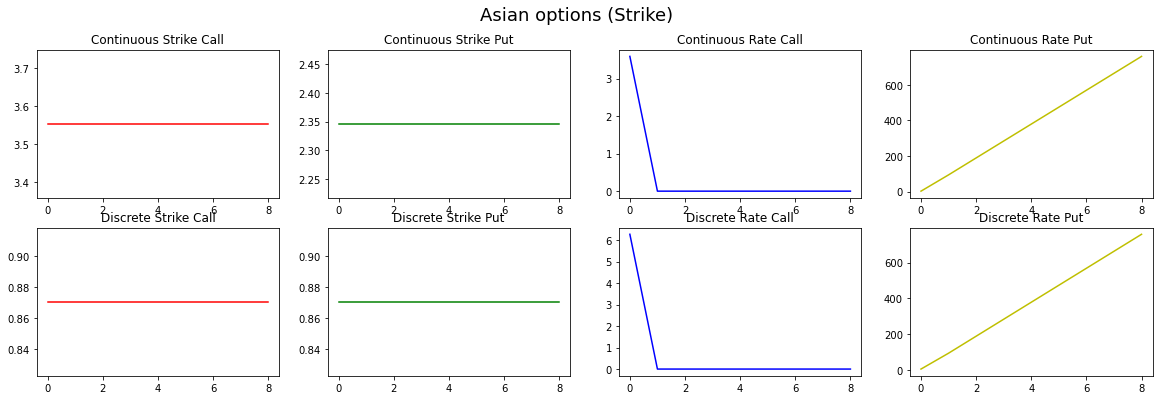

In [107]:
# Asian Option (Strike)

c_strike_calls, c_strike_puts, c_rate_calls, c_rate_puts = [], [], [], []
d_strike_calls, d_strike_puts, d_rate_calls, d_rate_puts = [], [], [], []

for strike_range in range(100, 1000, 100):
    
    asian = AsianOption(s0, strike_range, mu, sigma, horizon, timesteps, n_sims)

    c_strike_call, c_strike_put, c_rate_call, c_rate_put = asian.payoff_mean_continuous_arighmetic_average()

    c_strike_calls.append(c_strike_call)
    c_strike_puts.append(c_strike_put)
    c_rate_calls.append(c_rate_call)
    c_rate_puts.append(c_rate_put)

    d_strike_call, d_strike_put, d_rate_call, d_rate_put = asian.payoff_mean_discrete_arighmetic_average(window_size)

    d_strike_calls.append(d_strike_call)
    d_strike_puts.append(d_strike_put)
    d_rate_calls.append(d_rate_call)
    d_rate_puts.append(d_rate_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_strike_calls, color='r')
axes[0, 0].set_title('Continuous Strike Call')

axes[0, 1].plot(c_strike_puts, color='g')
axes[0, 1].set_title('Continuous Strike Put')

axes[0, 2].plot(c_rate_calls, color='b')
axes[0, 2].set_title('Continuous Rate Call')

axes[0, 3].plot(c_rate_puts, color='y')
axes[0, 3].set_title('Continuous Rate Put')

axes[1, 0].plot(d_strike_calls, color='r')
axes[1, 0].set_title('Discrete Strike Call')

axes[1, 1].plot(d_strike_puts, color='g')
axes[1, 1].set_title('Discrete Strike Put')

axes[1, 2].plot(d_rate_calls, color='b')
axes[1, 2].set_title('Discrete Rate Call')

axes[1, 3].plot(d_rate_puts, color='y')
axes[1, 3].set_title('Discrete Rate Put')

plt.suptitle('Asian options (Strike)', fontsize = 18)

Text(0.5, 0.98, 'Lookback options (Strike)')

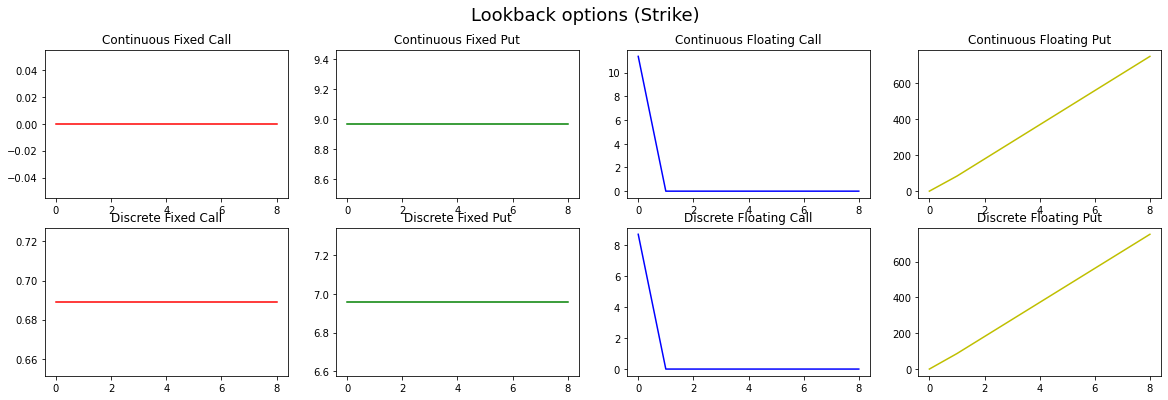

In [108]:
# Lookback Option (Strike)

c_fixed_calls, c_fixed_puts, c_floating_calls, c_floating_puts = [], [], [], []
d_fixed_calls, d_fixed_puts, d_floating_calls, d_floating_puts = [], [], [], []

for strike_range in range(100, 1000, 100):
    
    lookback = LookbackOption(s0, strike_range, mu, sigma, horizon, timesteps, n_sims)

    c_fixed_call, c_fixed_put, c_floating_call, c_floating_put = lookback.payoff_mean_continuous()

    c_fixed_calls.append(c_fixed_call)
    c_fixed_puts.append(c_fixed_put)
    c_floating_calls.append(c_floating_call)
    c_floating_puts.append(c_floating_put)

    d_fixed_call, d_fixed_put, d_floating_call, d_floating_put = lookback.payoff_mean_discrete(window_size)

    d_fixed_calls.append(d_fixed_call)
    d_fixed_puts.append(d_fixed_put)
    d_floating_calls.append(d_floating_call)
    d_floating_puts.append(d_floating_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_fixed_calls, color='r')
axes[0, 0].set_title('Continuous Fixed Call')

axes[0, 1].plot(c_fixed_puts, color='g')
axes[0, 1].set_title('Continuous Fixed Put')

axes[0, 2].plot(c_floating_calls, color='b')
axes[0, 2].set_title('Continuous Floating Call')

axes[0, 3].plot(c_floating_puts, color='y')
axes[0, 3].set_title('Continuous Floating Put')

axes[1, 0].plot(d_fixed_calls, color='r')
axes[1, 0].set_title('Discrete Fixed Call')

axes[1, 1].plot(d_fixed_puts, color='g')
axes[1, 1].set_title('Discrete Fixed Put')

axes[1, 2].plot(d_floating_calls, color='b')
axes[1, 2].set_title('Discrete Floating Call')

axes[1, 3].plot(d_floating_puts, color='y')
axes[1, 3].set_title('Discrete Floating Put')

plt.suptitle('Lookback options (Strike)', fontsize = 18)

#### 4.3 Time to Expiry

Text(0.5, 0.98, 'Asian options (Time to Expiry)')

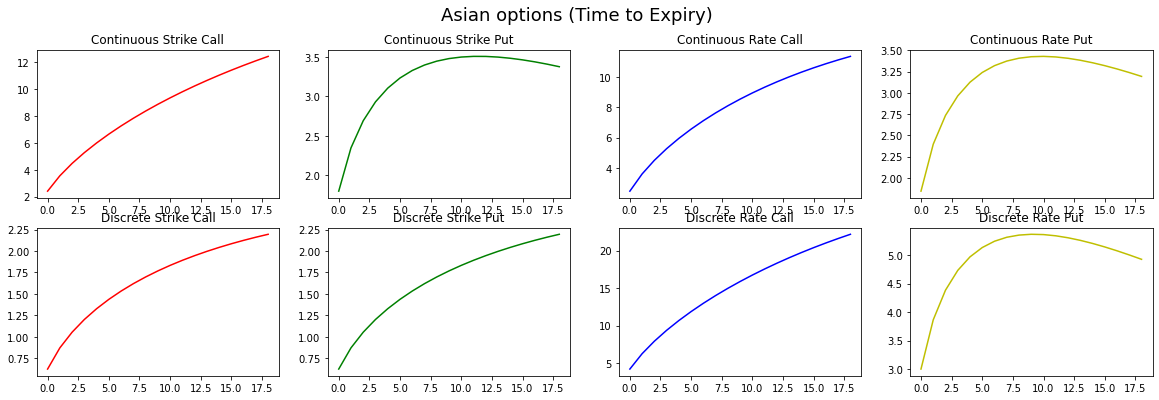

In [109]:
# Asian Option (Time to Expiry)

c_strike_calls, c_strike_puts, c_rate_calls, c_rate_puts = [], [], [], []
d_strike_calls, d_strike_puts, d_rate_calls, d_rate_puts = [], [], [], []

for horizon_range in range(5, 100, 5):
    
    asian = AsianOption(s0, strike, mu, sigma, horizon_range / 10, timesteps, n_sims)

    c_strike_call, c_strike_put, c_rate_call, c_rate_put = asian.payoff_mean_continuous_arighmetic_average()

    c_strike_calls.append(c_strike_call)
    c_strike_puts.append(c_strike_put)
    c_rate_calls.append(c_rate_call)
    c_rate_puts.append(c_rate_put)

    d_strike_call, d_strike_put, d_rate_call, d_rate_put = asian.payoff_mean_discrete_arighmetic_average(window_size)

    d_strike_calls.append(d_strike_call)
    d_strike_puts.append(d_strike_put)
    d_rate_calls.append(d_rate_call)
    d_rate_puts.append(d_rate_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_strike_calls, color='r')
axes[0, 0].set_title('Continuous Strike Call')

axes[0, 1].plot(c_strike_puts, color='g')
axes[0, 1].set_title('Continuous Strike Put')

axes[0, 2].plot(c_rate_calls, color='b')
axes[0, 2].set_title('Continuous Rate Call')

axes[0, 3].plot(c_rate_puts, color='y')
axes[0, 3].set_title('Continuous Rate Put')

axes[1, 0].plot(d_strike_calls, color='r')
axes[1, 0].set_title('Discrete Strike Call')

axes[1, 1].plot(d_strike_puts, color='g')
axes[1, 1].set_title('Discrete Strike Put')

axes[1, 2].plot(d_rate_calls, color='b')
axes[1, 2].set_title('Discrete Rate Call')

axes[1, 3].plot(d_rate_puts, color='y')
axes[1, 3].set_title('Discrete Rate Put')

plt.suptitle('Asian options (Time to Expiry)', fontsize = 18)

Text(0.5, 0.98, 'Lookback options (Time to Expiry)')

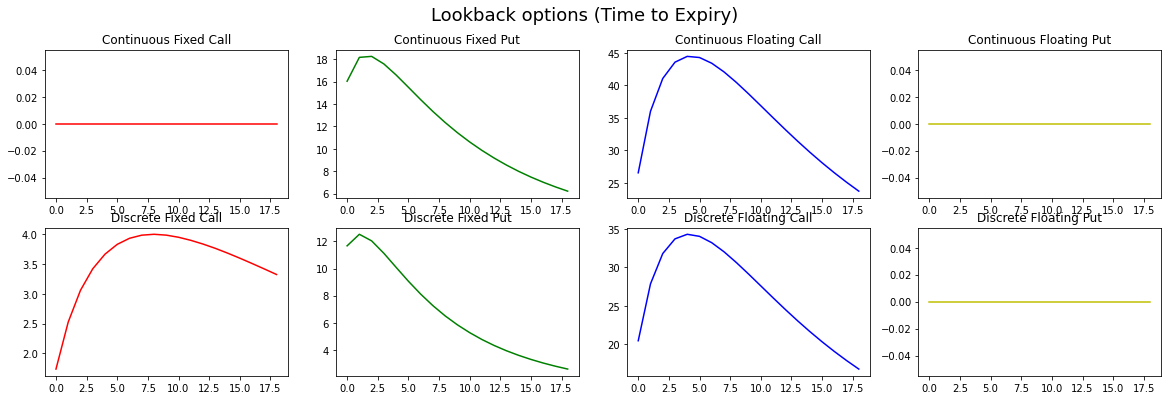

In [110]:
# Lookback Option (Time to Expiry)

c_fixed_calls, c_fixed_puts, c_floating_calls, c_floating_puts = [], [], [], []
d_fixed_calls, d_fixed_puts, d_floating_calls, d_floating_puts = [], [], [], []

for horizon_range in range(5, 100, 5):
    
    lookback = LookbackOption(s0, strike, mu, sigma, horizon_range, timesteps, n_sims)

    c_fixed_call, c_fixed_put, c_floating_call, c_floating_put = lookback.payoff_mean_continuous()

    c_fixed_calls.append(c_fixed_call)
    c_fixed_puts.append(c_fixed_put)
    c_floating_calls.append(c_floating_call)
    c_floating_puts.append(c_floating_put)

    d_fixed_call, d_fixed_put, d_floating_call, d_floating_put = lookback.payoff_mean_discrete(window_size)

    d_fixed_calls.append(d_fixed_call)
    d_fixed_puts.append(d_fixed_put)
    d_floating_calls.append(d_floating_call)
    d_floating_puts.append(d_floating_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_fixed_calls, color='r')
axes[0, 0].set_title('Continuous Fixed Call')

axes[0, 1].plot(c_fixed_puts, color='g')
axes[0, 1].set_title('Continuous Fixed Put')

axes[0, 2].plot(c_floating_calls, color='b')
axes[0, 2].set_title('Continuous Floating Call')

axes[0, 3].plot(c_floating_puts, color='y')
axes[0, 3].set_title('Continuous Floating Put')

axes[1, 0].plot(d_fixed_calls, color='r')
axes[1, 0].set_title('Discrete Fixed Call')

axes[1, 1].plot(d_fixed_puts, color='g')
axes[1, 1].set_title('Discrete Fixed Put')

axes[1, 2].plot(d_floating_calls, color='b')
axes[1, 2].set_title('Discrete Floating Call')

axes[1, 3].plot(d_floating_puts, color='y')
axes[1, 3].set_title('Discrete Floating Put')

plt.suptitle('Lookback options (Time to Expiry)', fontsize = 18)

#### 4.4 Volatility

Text(0.5, 0.98, 'Asian options (Volatility)')

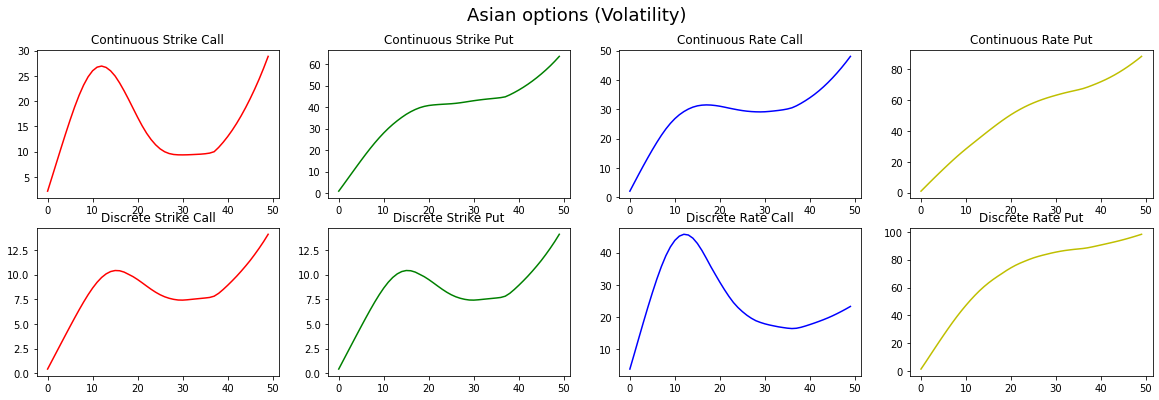

In [111]:
# Asian Option (Volatility)

c_strike_calls, c_strike_puts, c_rate_calls, c_rate_puts = [], [], [], []
d_strike_calls, d_strike_puts, d_rate_calls, d_rate_puts = [], [], [], []

for sigma_range in range(10, 1000, 20):
    
    asian = AsianOption(s0, strike, mu, sigma_range / 100, horizon, timesteps, n_sims)

    c_strike_call, c_strike_put, c_rate_call, c_rate_put = asian.payoff_mean_continuous_arighmetic_average()

    c_strike_calls.append(c_strike_call)
    c_strike_puts.append(c_strike_put)
    c_rate_calls.append(c_rate_call)
    c_rate_puts.append(c_rate_put)

    d_strike_call, d_strike_put, d_rate_call, d_rate_put = asian.payoff_mean_discrete_arighmetic_average(window_size)

    d_strike_calls.append(d_strike_call)
    d_strike_puts.append(d_strike_put)
    d_rate_calls.append(d_rate_call)
    d_rate_puts.append(d_rate_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_strike_calls, color='r')
axes[0, 0].set_title('Continuous Strike Call')

axes[0, 1].plot(c_strike_puts, color='g')
axes[0, 1].set_title('Continuous Strike Put')

axes[0, 2].plot(c_rate_calls, color='b')
axes[0, 2].set_title('Continuous Rate Call')

axes[0, 3].plot(c_rate_puts, color='y')
axes[0, 3].set_title('Continuous Rate Put')

axes[1, 0].plot(d_strike_calls, color='r')
axes[1, 0].set_title('Discrete Strike Call')

axes[1, 1].plot(d_strike_puts, color='g')
axes[1, 1].set_title('Discrete Strike Put')

axes[1, 2].plot(d_rate_calls, color='b')
axes[1, 2].set_title('Discrete Rate Call')

axes[1, 3].plot(d_rate_puts, color='y')
axes[1, 3].set_title('Discrete Rate Put')

plt.suptitle('Asian options (Volatility)', fontsize = 18)

Text(0.5, 0.98, 'Lookback options (Volatility)')

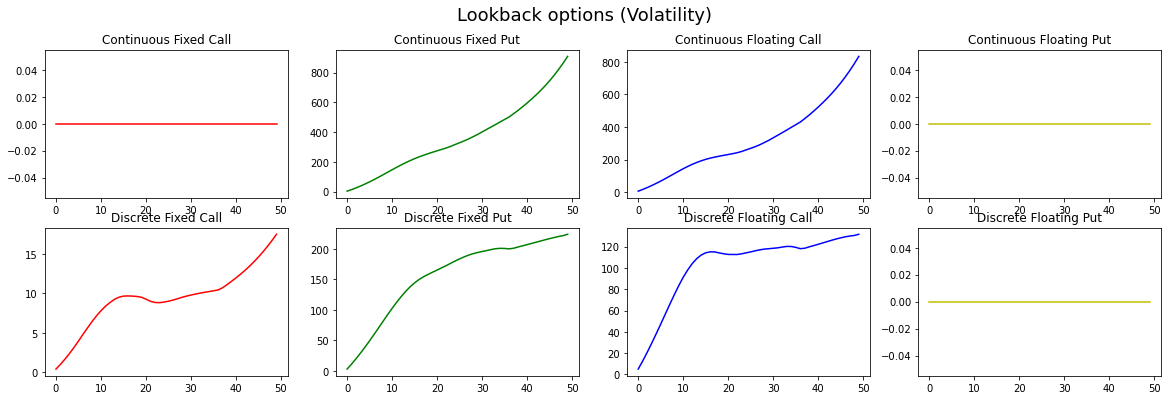

In [112]:
# Lookback Option (Volatility)

c_fixed_calls, c_fixed_puts, c_floating_calls, c_floating_puts = [], [], [], []
d_fixed_calls, d_fixed_puts, d_floating_calls, d_floating_puts = [], [], [], []

for sigma_range in range(10, 1000, 20):
    
    lookback = LookbackOption(s0, strike, mu, sigma_range / 100, horizon, timesteps, n_sims)

    c_fixed_call, c_fixed_put, c_floating_call, c_floating_put = lookback.payoff_mean_continuous()

    c_fixed_calls.append(c_fixed_call)
    c_fixed_puts.append(c_fixed_put)
    c_floating_calls.append(c_floating_call)
    c_floating_puts.append(c_floating_put)

    d_fixed_call, d_fixed_put, d_floating_call, d_floating_put = lookback.payoff_mean_discrete(window_size)

    d_fixed_calls.append(d_fixed_call)
    d_fixed_puts.append(d_fixed_put)
    d_floating_calls.append(d_floating_call)
    d_floating_puts.append(d_floating_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_fixed_calls, color='r')
axes[0, 0].set_title('Continuous Fixed Call')

axes[0, 1].plot(c_fixed_puts, color='g')
axes[0, 1].set_title('Continuous Fixed Put')

axes[0, 2].plot(c_floating_calls, color='b')
axes[0, 2].set_title('Continuous Floating Call')

axes[0, 3].plot(c_floating_puts, color='y')
axes[0, 3].set_title('Continuous Floating Put')

axes[1, 0].plot(d_fixed_calls, color='r')
axes[1, 0].set_title('Discrete Fixed Call')

axes[1, 1].plot(d_fixed_puts, color='g')
axes[1, 1].set_title('Discrete Fixed Put')

axes[1, 2].plot(d_floating_calls, color='b')
axes[1, 2].set_title('Discrete Floating Call')

axes[1, 3].plot(d_floating_puts, color='y')
axes[1, 3].set_title('Discrete Floating Put')

plt.suptitle('Lookback options (Volatility)', fontsize = 18)

#### 4.5 Risk-Free Interest Rate


Text(0.5, 0.98, 'Asian options (Risk-Free Interest Rate)')

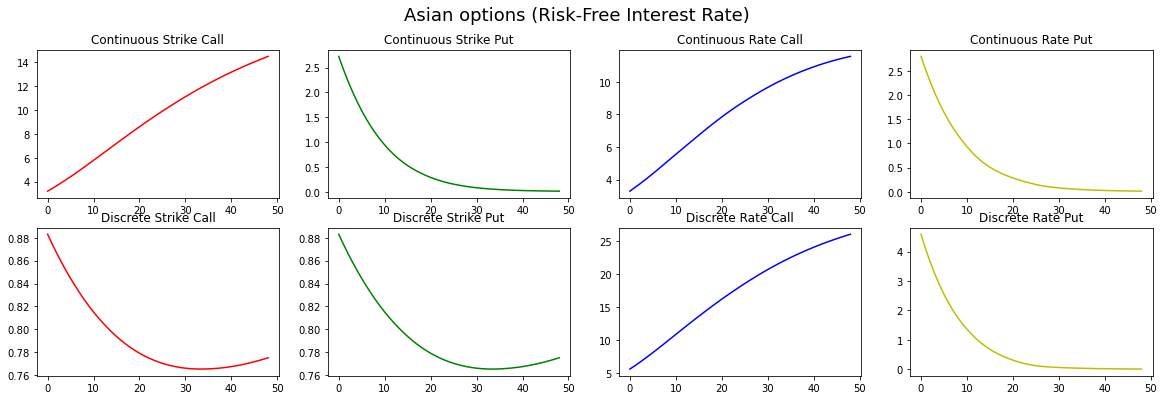

In [113]:
# Asian Option (Risk-Free Interest Rate)

c_strike_calls, c_strike_puts, c_rate_calls, c_rate_puts = [], [], [], []
d_strike_calls, d_strike_puts, d_rate_calls, d_rate_puts = [], [], [], []

for rate_range in range(2, 100, 2):
    
    asian = AsianOption(s0, strike, rate_range / 100, sigma, horizon, timesteps, n_sims)

    c_strike_call, c_strike_put, c_rate_call, c_rate_put = asian.payoff_mean_continuous_arighmetic_average()

    c_strike_calls.append(c_strike_call)
    c_strike_puts.append(c_strike_put)
    c_rate_calls.append(c_rate_call)
    c_rate_puts.append(c_rate_put)

    d_strike_call, d_strike_put, d_rate_call, d_rate_put = asian.payoff_mean_discrete_arighmetic_average(window_size)

    d_strike_calls.append(d_strike_call)
    d_strike_puts.append(d_strike_put)
    d_rate_calls.append(d_rate_call)
    d_rate_puts.append(d_rate_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_strike_calls, color='r')
axes[0, 0].set_title('Continuous Strike Call')

axes[0, 1].plot(c_strike_puts, color='g')
axes[0, 1].set_title('Continuous Strike Put')

axes[0, 2].plot(c_rate_calls, color='b')
axes[0, 2].set_title('Continuous Rate Call')

axes[0, 3].plot(c_rate_puts, color='y')
axes[0, 3].set_title('Continuous Rate Put')

axes[1, 0].plot(d_strike_calls, color='r')
axes[1, 0].set_title('Discrete Strike Call')

axes[1, 1].plot(d_strike_puts, color='g')
axes[1, 1].set_title('Discrete Strike Put')

axes[1, 2].plot(d_rate_calls, color='b')
axes[1, 2].set_title('Discrete Rate Call')

axes[1, 3].plot(d_rate_puts, color='y')
axes[1, 3].set_title('Discrete Rate Put')

plt.suptitle('Asian options (Risk-Free Interest Rate)', fontsize = 18)

Text(0.5, 0.98, 'Lookback options (Risk-Free Interest Rate)')

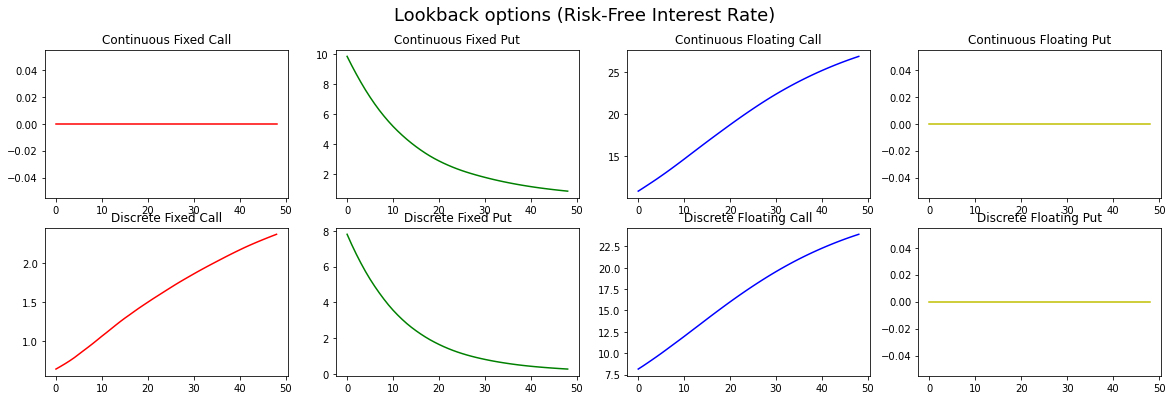

In [114]:
# Lookback Option (Risk-Free Interest Rate)

c_fixed_calls, c_fixed_puts, c_floating_calls, c_floating_puts = [], [], [], []
d_fixed_calls, d_fixed_puts, d_floating_calls, d_floating_puts = [], [], [], []

for rate_range in range(2, 100, 2):
    
    lookback = LookbackOption(s0, strike, rate_range / 100, sigma, horizon, timesteps, n_sims)

    c_fixed_call, c_fixed_put, c_floating_call, c_floating_put = lookback.payoff_mean_continuous()

    c_fixed_calls.append(c_fixed_call)
    c_fixed_puts.append(c_fixed_put)
    c_floating_calls.append(c_floating_call)
    c_floating_puts.append(c_floating_put)

    d_fixed_call, d_fixed_put, d_floating_call, d_floating_put = lookback.payoff_mean_discrete(window_size)

    d_fixed_calls.append(d_fixed_call)
    d_fixed_puts.append(d_fixed_put)
    d_floating_calls.append(d_floating_call)
    d_floating_puts.append(d_floating_put)

figure, axes = plt.subplots(2, 4, figsize=(20,6))

axes[0, 0].plot(c_fixed_calls, color='r')
axes[0, 0].set_title('Continuous Fixed Call')

axes[0, 1].plot(c_fixed_puts, color='g')
axes[0, 1].set_title('Continuous Fixed Put')

axes[0, 2].plot(c_floating_calls, color='b')
axes[0, 2].set_title('Continuous Floating Call')

axes[0, 3].plot(c_floating_puts, color='y')
axes[0, 3].set_title('Continuous Floating Put')

axes[1, 0].plot(d_fixed_calls, color='r')
axes[1, 0].set_title('Discrete Fixed Call')

axes[1, 1].plot(d_fixed_puts, color='g')
axes[1, 1].set_title('Discrete Fixed Put')

axes[1, 2].plot(d_floating_calls, color='b')
axes[1, 2].set_title('Discrete Floating Call')

axes[1, 3].plot(d_floating_puts, color='y')
axes[1, 3].set_title('Discrete Floating Put')

plt.suptitle('Lookback options (Risk-Free Interest Rate)', fontsize = 18)

### 5 Conclusion

In this report, we use Monte Carlo Simulation to explore and implement the Asian Option and the Lookback Option pricing. We discusse both averaging methods (arithmetic average and geometric average) and from the experiment result, we find that there is no significant difference between them and choose the Arithmetic Average in the following experiment. Then, we focus on the time scheme (continuous and discrete) and the strike scheme (fixed strike and floating strike) of the Asian Option and the Lookback Option. Finally, we try to vary the variables to see the affect on the option price. 

Moreover, the option price shows different based on the different variables. Some further research may be carried out in the future to find the dynamic optimization solution and the prediction in the more complex environment.

#### 6 References

- [1] Paul Wilmott on Quantitative Finance Volume 2, Paul Wilmott, John Wiley & Sons Ltd., 2006, P428-P443, P445-P452
- [2] CQF Course M3 L1 - The Black–Scholes Model
- [3] CQF Course M3 L2 - Martingales Theory Application to Option Pricing
- [4] CQF Course M3 L3 - Martingales and PDEs Which When and Why
- [5] CQF Course M3 L5 - Exotic Options